# Preprocessing
     
In this notebook, we go through steps to :
- embed the population size measurement into the `AnnData.uns['pop']`.
- rename timepoint obs key
- perform dimension reduction : diffusion map 
- sample local state transition
- train test split

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
if sys.platform.startswith("darwin"):
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scanpy as sc
sc.settings.set_figure_params(frameon=False, dpi=30)

import our python package as `pdp` (***p***seudo ***d***ynamics ***p***lus)

In [3]:
import pseudodynamics as pdp

In [4]:
os.chdir(pdp.main_dir)
print("workding directory changed to:", pdp.main_dir)

workding directory changed to: /Users/weizhongzheng/Documents/python_project/pseudodynamics_plus


# mouse *in vivo* BM haematopoiesis  

In this tutorial, we use a special persistent labling single-cell data from [Kucinski & Barile et. al, Cell Stem Cell. 2024](https://doi.org/10.1016/j.stem.2023.12.001).  

Persistent labeling technique can induces fluorescence in Hoxb5-expressing cells and propogate the label to their progenies. As a result, we can identify offsprings of haematopoitic stem and progenitor cells (HSPC) produced after induction from the by checking the tomato fluorescence (Tom+). 

  
This dataset contains 130700 cells from 9 timepoints spanning 9 month's time. At each time point we counted the total amount of Tom+ cells in the bone marrow of the mice.


The data is available at [figshare](https://figshare.com/ndownloader/articles/25398766/versions/3) 👈, or you can download it with the bash script `data_downloading.sh`.

In [4]:
# we can download the expression matrix together with experimental settings

# create a data folder 
if not os.path.exists("data"):
    os.mkdir("data")

In [ ]:
adata_full = sc.read_h5ad("data/tompos/combined_filt.h5ad")
adata_full

AnnData object with n_obs × n_vars = 130700 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime'
    var: 'symbol', 'gene_ids-10x', 'feature_types-10x', 'genome-10x', 'n_counts-10x', 'highly_variable-10x', 'means-10x', 'dispersions-10x', 

## Data overview and filtering
The preprocess single-cell landscape is batch-correted and cell type annotated.

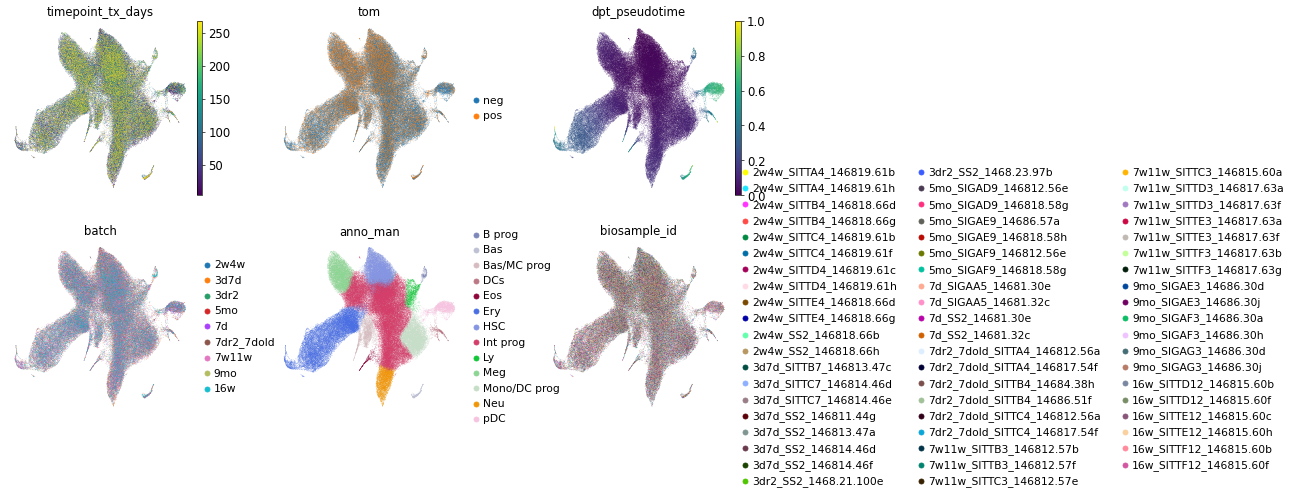

In [ ]:
sc.pl.umap(adata_full, 
           color=['timepoint_tx_days', 'tom', 'dpt_pseudotime',
                         'batch',  'anno_man', 'biosample_id', ], 
           ncols=3, wspace=0.3)

### filtering Tom+ cells  

For this particular data, the newly generated cells are labeled with fluorensence. We thus filtered Tomato-positive (Tom+) cells and count the number of all the Tom+ cells in the bone marrow. At each time point, we sequenced and FACS-counted cells from several mouse. 

In [ ]:
# select positive cells and saved under data
adata = adata_full[adata_full.obs['tom'] == 'pos'].copy()
adata.write_h5ad('data/tom_pos.h5ad')

<font size=4 color='red'>Important !!!  </font> 


<font size=4> To train the model, you need to placed the processed data under `data`.
</font>

# 1. Attaching population size measurement

One of the main innovations of ***pseudodyanmics+*** is the use of population/tissue size measurement that comes from additional experiment, considering single-cell experiment has the issue of limiting capacity and sampling bias. 

However, for dataset that without tissue size measurement, we can go back to sequenced cell number in the sc library. <font color='red'> The parameters inferred in this manner may fail to reflect the absolute tissue growth and flux transiting between cell state. </font>

The population info is stored as a dictionary and saved in `adata.uns['pop']`. The `pop` dictionary must contain the following keys:
- `'t'` : the real experiment time point when the cells are counted and sequenced (assume on the same day)
- `'mean'` : the mean cell number of different experimental repeats for each time point
- `'std'` : the standard derivation of different experimental repeats 
- `'n_lib'` : the number of repeats 

For example, a single cell data with 3 time points (say day0, day4, day10) and 3 repeats each time looks like this:
 
```Python
    adata.uns['pop'] = {
        "t" = np.array([0, 4, 10]),
        "mean" = np.array([mean_d0, mean_d4, mean_d10]),
        "std" = np.array([std_d0, std_d4, std_d10]),
        "n_lib" = np.array([3, 3, 3])
    }
```

In [5]:
adata = sc.read_h5ad('data/tom_pos.h5ad')
adata

AnnData object with n_obs × n_vars = 49390 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime', 'leiden_orig', 'logk', 'net_prolif', 'log10SR', 'log_density_at_E3', 'log_density_at_E7', 'log_density_at_E12', 'log_density_at_E12_clip', 'l

### load FACS data

Here we are loading the FACS experiment data. The BM cells of the same mouse are sorted for tomato positive and count total cell number before sending for sequencing.

In [7]:
pop_df = pd.read_csv("data/tompos/model_input_tompos.csv")
pop_df.head()

,biosample_id,0,1,2,3,4,5,6,7,8,...,20,24,25,26,28,sc_ncells_filt,flow_total,start_age,time,sc_ncells_total
0,2w4w_SITTC4_146819.61b,42,16,8,5,15,7,3,19,28,...,0,0,0,0,0,157,634.907992,young,27,161
1,2w4w_SITTC4_146819.61f,184,122,103,109,118,97,73,149,146,...,4,11,2,5,2,1304,2320.519107,young,27,1357
2,2w4w_SITTD4_146819.61c,257,122,107,76,116,120,78,175,161,...,7,4,3,2,1,1422,3535.791587,young,27,1449
3,2w4w_SITTD4_146819.61h,98,61,42,45,42,26,28,52,76,...,2,2,0,1,0,547,895.421264,young,27,563
4,2w4w_SITTE4_146818.66d,35,10,10,9,6,16,4,19,16,...,0,0,0,1,0,137,456.845376,young,12,143


We summarize the total cell number over different mouse for each time point

In [8]:
pop_by_time = pop_df.groupby("time").agg({"flow_total":["mean", "std","count"], "sc_ncells_filt":["mean", "std"]})
pop_by_time

flow_total                    sc_ncells_filt             
              mean          std count           mean          std
time                                                             
3       147.000000    45.745674     4         101.00    36.487441
7       388.645708   254.329995     6         150.50    69.856281
12      576.692900   169.724308     4         155.25   106.859331
27     1846.659988  1347.949806     4         857.50   606.941238
49     3123.277705  2110.007646     4        1143.00   813.058833
76     8233.932637   446.605979     2        2678.00   560.028571
112   13949.548025  6560.283561     4        3003.25  1733.310392
161    4941.850616  3795.978265     4        1854.25  1635.804262
269   41722.985970  1788.570460     2        4320.75  1446.069241

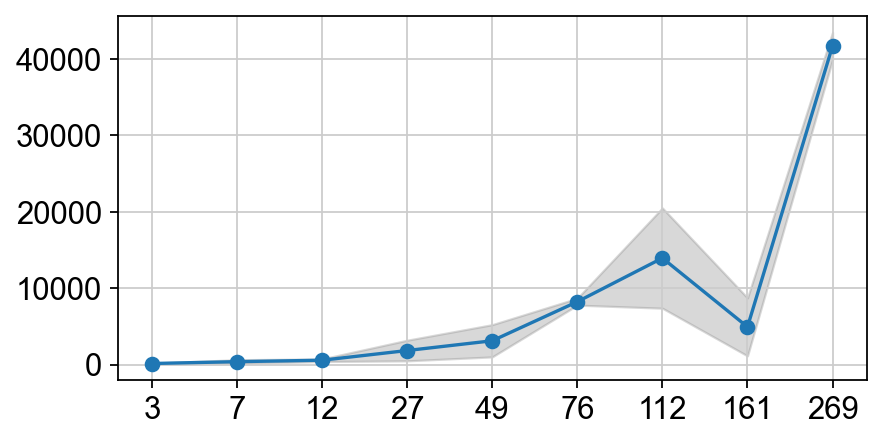

In [10]:
import matplotlib.pyplot as plt


def plot_mean_std(col_name, ax):
    time_points = pop_by_time.index
    mean_values = pop_by_time[(col_name, 'mean')]
    std_values = pop_by_time[(col_name, 'std')]

    ax.plot(range(len(time_points)), mean_values, marker='o', label=col_name)
    ax.fill_between(range(len(time_points)), 
                    mean_values - std_values, 
                    mean_values + std_values, 
                    alpha=0.3, color='gray', label=col_name+"_error")
    ax.set_xticks(range(len(time_points)))
    ax.set_xticklabels(time_points)

fig = plt.figure(dpi=80, figsize=(6, 3))
ax = fig.gca()
plot_mean_std('flow_total', ax=ax)

Here we found that the measurment at Day 161 seems to be an outlier. We do the following correction :

- we estimate the average growth rate from Day112 to Day269 with $ N_t = N_0 * e^{g \Delta t}$
- next we impute the mean pop size at Day161 with the average growth rate

In [11]:
time_points = pop_by_time.index
mean_values = pop_by_time[('flow_total', 'mean')].values
g = np.log(mean_values[-1]  / mean_values[-3]) / (time_points[-1] - time_points[-3]) 
print(f'the estimated mean g is {g:.5f}')

impute_Day161 = np.exp(g*(time_points[-2] - time_points[-3]) ) * mean_values[-3]
print(f'the imputed mean pop size is {impute_Day161:.2f}')

# replace the mean value
mean_values[-2] = impute_Day161

the estimated mean g is 0.00698
the imputed mean pop size is 19636.45


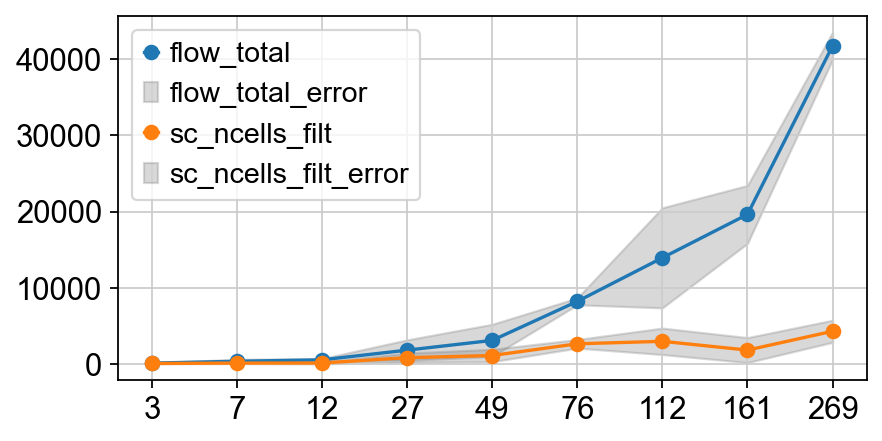

In [12]:
fig = plt.figure(dpi=80, figsize=(6, 3))
ax = fig.gca()
plot_mean_std('flow_total', ax)
plot_mean_std('sc_ncells_filt', ax)
ax.legend()

In [ ]:
# assign to uns['pop']

adata.uns['pop'] = {
    't' : time_points.to_numpy(),
    'mean' : mean_values,
    'std' : pop_by_time[('flow_total', 'std')].values,
    'n_lib' : pop_by_time[('flow_total', 'count')].values
}

adata.uns['pop'] 

{'t': array([  3,   7,  12,  27,  49,  76, 112, 161, 269]),
 'mean': array([  147.        ,   388.64570792,   576.69290022,  1846.6599877 ,
         3123.27770491,  8233.9326366 , 13949.54802458, 19636.45034395,
        41722.98597037]),
 'std': array([  45.74567375,  254.32999527,  169.72430757, 1347.94980559,
        2110.00764584,  446.60597854, 6560.28356116, 3795.97826525,
        1788.57045978]),
 'n_lib': array([4, 6, 4, 4, 4, 2, 4, 4, 2])}

# 2. rename Timepoint Key 

We use a unique obs key `timepoint_tx_days` to store the timepoint.

In [13]:
if 'timepoint_tx_days' not in adata.obs_keys():
    adata.obs['timepoint_tx_days'] = adata.obs['day'].astype(int) # example

check if the time point from the pop info match with that in the sequencing data

In [14]:
adata.obs['timepoint_tx_days'].isin(adata.uns['pop']['t']).all()

True

# 3. Compute diffusion map (DM)

The example dataset has pre-computed diffusion maps. For reproducibility, plesae keep the original diffusion map and pseudotime.  
Here, for demonstration, we show two popular methods of getting DM cooridnates and pseudotime.  
- scanpy diffusion map and dpt_psuedotime 
- palantir diffusion map and palantir pseudotime

In [8]:
adata

AnnData object with n_obs × n_vars = 49390 × 4814
    obs: 'n_genes', 'n_counts', 'mt_count', 'mt_frac', 'doublet_scores', 'predicted_doublets', 'xist_logn', 'Ygene_logn', 'xist_bin', 'Ygene_bin', 'sex_adata', 'biosample_id', 'cellid', 'RBG', 'SLXid', 'index', '10xsample_description', 'sex_mixed', 'sex_meta', 'mouse_id', 'sortedcells', 'expected_cells_10x', 'cellranger_cellsfound', 'chemistry', 'tom', 'expdate', 'batch', 'timepoint_tx_days', 'start_age', 'sample_id', 'countfile', 'S_score', 'G2M_score', 'phase', 'leiden', 'SLX', 'plate_sorted', 'plate_rearranged', 'well_sorted', 'well_rearranged', 'set_index', 'CI_index', 'mouse_platelabel', 'sort_method', 'sample.name', 'population', 'sex', 'countfolder', 'batch_plate_sorted', 'data_type', 'sex_combined', 'longname', 'anno_man', 'leiden_DM', 'HSCscore', 'nn_HSCscore', 'isroot', 'dpt_pseudotime', 'leiden_orig', 'logk', 'net_prolif', 'log10SR', 'log_density_at_E3', 'log_density_at_E7', 'log_density_at_E12', 'log_density_at_E12_clip', 'l

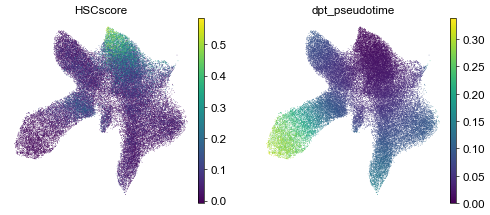

In [ ]:
if 'X_diffmap' not in adata.obsm_keys():
    # use batch corrected cell representation like Harmonied PC or SCVI latent
    sc.pp.neighbors(adata, n_pcs=30, use_rep='X_pca_harmony') 
    sc.tl.diffmap(adata, n_comps=10)

adata.uns['iroot']= np.argmin(adata.obs['HSCscore'].values)
sc.tl.dpt(adata)

sc.pl.umap(adata, color=['HSCscore', 'dpt_pseudotime'])

In [10]:
# next we scaled the diffusion map to 0-1.
DM = adata.obsm['X_diffmap']
DM_min = DM.min(axis=0,keepdims=True)
DM_range = DM.max(axis=0,keepdims=True) - DM_min
DM_scaled = (DM - DM_min)/DM_range

In [ ]:
import palantir
dm_res = palantir.utils.run_diffusion_maps(adata, pca_key='X_pca_harmony')
ms_data = palantir.utils.determine_multiscale_space(adata)

print(f"shape of palantir DM : {adata.obsm['DM_EigenVectors'].shape} and scaled DM : {adata.obsm['DM_EigenVectors_multiscaled'].shape} ")

# 4. Sample local cell state changes in diffusion map

***Pseudodynamics+*** can make use of the local cell state changes in diffusion map to assists learning velocity, inspired by [TrajectoryNet by Tong et. al.](https://arxiv.org/abs/2002.04461). This state changes is defined as $\Delta x = \sum_{i \in N(x)} \frac{w_{i,x}}{w_{i,x} + \sum_{j \in N(x)} w_{i,j}} \Delta x_i$ ,Here we provdie two ways of sampling this local state transition:

- by default we rely on KNN and pseudotime with $w_{i,j}$ denoting the connectivities in KNN.

- alternatively, when a transition matrix is provided, e.g. cellrank. The $w_{i,j}$ denote the probability of transitioning from $i$ to $j$.

In [ ]:
delta_DM , neighbors = pdp.tl.sample_deltax(adata, xkey='DM_scaled', pseudotimekey='dpt_pseudotime', repeat=10)
delta_DM_ay = np.stack(delta_DM)

print(delta_DM_ay.shape)
adata.obsm['Delta_DM'] = delta_DM_ay.mean(axis=-1) # use the averaged ∆DM

100%|██████████| 49390/49390 [00:06<00:00, 7459.89it/s]


(49390, 10, 30)


In [ ]:
adata.write_h5ad("data/tom_pos.h5ad")

# What's next 
- Estimate single-cell density at observed time point (optional). 
- set up training configuration
